# Unsupervised Learning Capstone

The aim of this capstone is to cluster our data set with unsupervised clustering methods and alternative models. 
For this purpose we used a data from a web site Turo.com, the biggest car sharing platform in the USA.
There are two problems that required unsupervised learning methods:
1. We need to cluster our data by location
2. Categorize all cars by their characteristics.
This information will help to continue the supervised learning and to create the predictive models.

**Location clustering**
For the purpose of location clustering we used the Latitude and Longtitude assosiated with every listing in the data. We approached our dataset with **k-means**, **dbscan** and **hierarhical clustering** techniques. We will use the siloughette score for each of the methodics to define how precise is every method.

**Car category clustering**
For this purpose we manually assigned categories for each car. We will try to do clustering with unsupervised clustering techniques ( **K-means**, **Hierarchical Clustering** and **DBSCAN**) with dimensionality reduction such as PSA and UMAP but more likely the best way will be to procees with the supervised classifier model. We will use neural network multi layer perceptron model and random forest to see what performs better.

In [251]:
#Import required libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.cluster import KMeans
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN

In [252]:
# importing all the data
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
df = pd.read_csv('Turo cars March 1 2018.csv')


In [253]:
#here is how our data looking
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168109 entries, 0 to 168108
Data columns (total 100 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Car ID                               168109 non-null  int64  
 1   URL                                  168109 non-null  object 
 2   Make                                 168109 non-null  object 
 3   Model                                168108 non-null  object 
 4   Trim                                 44008 non-null   object 
 5   Year                                 168109 non-null  int64  
 6   Color                                60377 non-null   object 
 7   Transmission                         168109 non-null  object 
 8   Fuel Type                            70907 non-null   object 
 9   Number of seats                      69655 non-null   float64
 10  Number of doors                      70911 non-null   float64
 11  GPS         

# Basic data exploration


At this stage we will check the sanity of the data, make observations on the data type, missing values, shape of the data

In [254]:
# Remove all columns between column index 70 to 99 
df.drop(df.iloc[:, 69:100], inplace = True, axis = 1) 
#replace all the missing data with 0 (we'll be checking later if we need to adjust this 0 for some variables)
df = df.fillna(0)

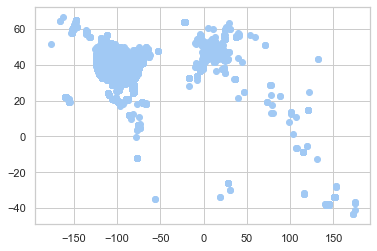

In [255]:
#mapping our location distribution
import matplotlib.pyplot as plt
plt.scatter(x=df['Longitude'], y=df['Latitude'])
plt.show()

In [256]:
#drop all non-active car listings
df = df[df['Status'] == "Active"]

In [257]:
#Let's scale the variables 
scaler = StandardScaler()
df[['Latitude']] = scaler.fit_transform(df[['Latitude']])
df[['Longitude']] = scaler.fit_transform(df[['Longitude']])

For car clusterization purposes we're going to use these variables: 
- 'Price per day'
- 'Year'
- 'Number of seats'
- 'Number of doors'
- 'Convertible' 
- 'Fuel Type'
- 'Make'
- 'highValueVehicle'
- 'Transmission'
- "MinAge"


Our target pre-labeled variable is
- "Category"

### Introducing  Category   variable

In [258]:
#combining make and model into category name
df1 = pd.read_csv ('Category_DB.csv', encoding='ISO-8859–1')
df['for category']= df['Make']+df['Model']
df = pd.merge (df, df1[['Car ID', 'Category']], on  = 'Car ID', how="left")

### Clean the variables if needed

In [259]:
#adjust some text errors
df.Make = df.Make.str.lower()
df.Model = df.Model.str.lower()
df.Category = df.Category.astype('category')
df.Category = df.Category.str.lower()
df = df[df['Category'].notnull()]

In [260]:
df.Category = df.Category.astype('category')
df['Category_code'] = df['Category'].cat.codes

In [261]:
df.groupby("Category")["Category"].count()

Category
cargo van          25
convertible      2358
economy          6518
electric         1521
exotic           3811
intermediate    11127
minivan          1681
motorhome           5
premium          4804
premium suv      4427
retro             437
suv              5498
truck            1363
van               103
Name: Category, dtype: int64

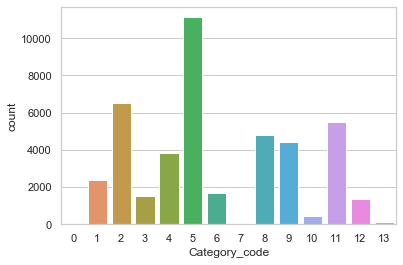

In [262]:
#Here is the categorized distribution of the variable:
sns.countplot(x=df['Category_code']);

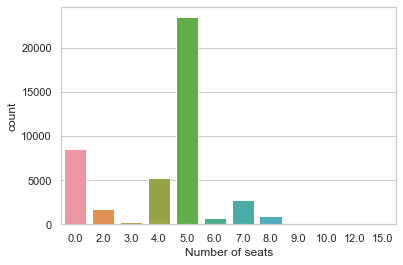

In [263]:
#Here is the categorized distribution of the variable:
sns.countplot(x=df['Number of seats']);

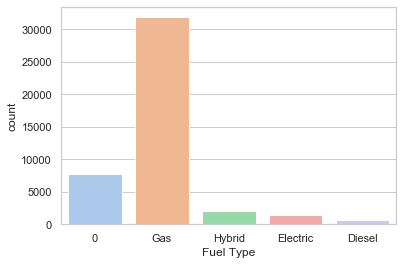

In [264]:
sns.countplot(x=df['Fuel Type']);

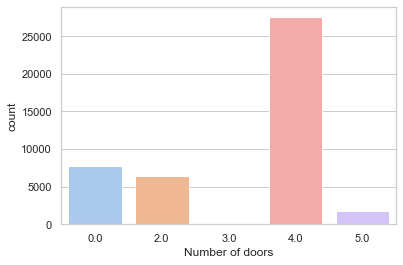

In [265]:
sns.countplot(x=df['Number of doors']);

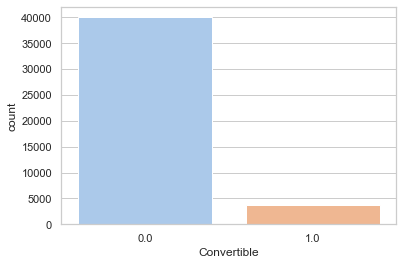

In [266]:
sns.countplot(x=df['Convertible']);

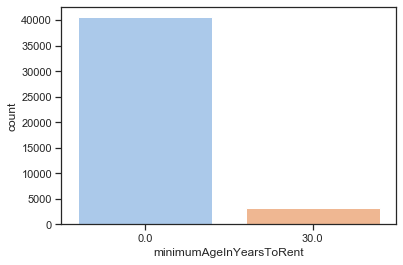

In [271]:
sns.countplot(x=df['minimumAgeInYearsToRent']);

Let's do some work for null variables:

In [267]:
df["Number of seats"].fillna(df["Number of seats"].mean(), inplace=True)
df["Number of doors"].fillna(df["Number of doors"].mean(), inplace=True)
df['Fuel Type'] = df['Fuel Type'].astype(str)
df['Fuel Type'] = df['Fuel Type'].apply( lambda x: x.replace ('0', 'Gas'))

### Potential outliers 

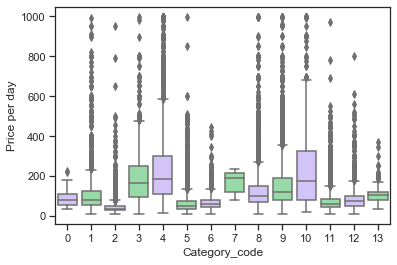

In [325]:
#Checking pricing by categories
sns.set(style="ticks", palette="pastel")


# Draw a nested boxplot to show bills by day and time
chart = sns.boxplot(x="Category_code", y="Price per day", palette=["m", "g"],
            data=df)


We decided not to remove outliers because of the nature of data and actual important output from the car owners about the price if very significant and can be truthful. 

# CLUSTERIZATION

## k-means clustering for location

The first problem that we're solving is to be able to separate our listings by location. 
We would like to use k-means because our data has only two variables that are measurements of distance. K-means should be the best fir for it however we're going to validate with other methods as well.

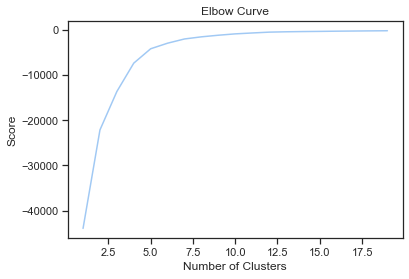

In [303]:
# Variable with the Longitude and Latitude
Z = df[['Car ID','Latitude','Longitude']]
K_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['Latitude']]
X_axis = df[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize the amount of clusters
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [304]:
#Let's define labels for location
kmeans = KMeans(n_clusters = 12, init ='k-means++')
kmeans.fit(Z[Z.columns[1:3]]) # Compute k-means clustering.
Z['cluster_label'] = kmeans.fit_predict(Z[Z.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(Z[Z.columns[1:3]]) # Labels of each point

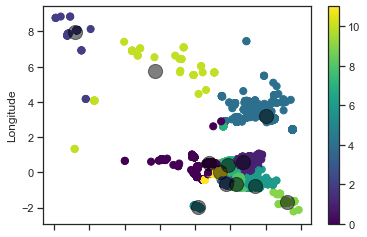

In [305]:
#put them on the plot
Z.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [9]:
#This is our silhouette score for k-means
print(metrics.silhouette_score(Z[Z.columns[1:3]], labels, metric='euclidean'))

0.6456396547584401


## DBSCAN Clustering for Location

In [10]:
# Defining the agglomerative clustering
dbscan_cluster_l = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster_l.fit_predict(Z[Z.columns[1:3]])

In [11]:
print(metrics.silhouette_score(Z[Z.columns[1:3]], clusters, metric='euclidean'))

0.0023567980682241657


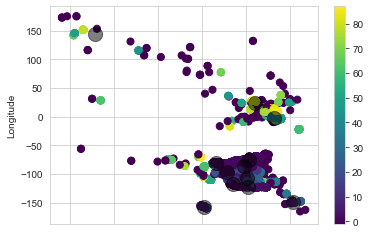

In [12]:
Z.plot.scatter(x = 'Latitude', y = 'Longitude', c = clusters, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

This is definitely won't be our choise based on the silhougtette score

## Hierarchical clustering for location

In [13]:
from sklearn.cluster import AgglomerativeClustering

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)
# Fit model
clusters_h = agg_cluster.fit_predict(Z[Z.columns[1:3]])

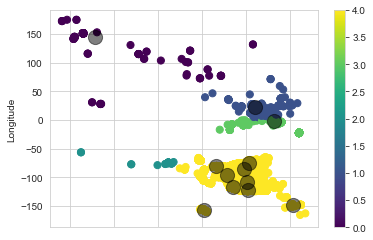

In [14]:
Z.plot.scatter(x = 'Latitude', y = 'Longitude', c = clusters_h, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [15]:
print(metrics.silhouette_score(Z[Z.columns[1:3]], clusters_h, metric='euclidean'))

0.43172051126894256


This result is better but still worth than K-means

# Performance of location clustering algorithm

We found that k-means work the best way for the location clustering. The siloughette score is 0.65. Let's review the clusters:

In [314]:
### Adding location cluster into the dataframe and will do a visual inspetion
df = df.merge(Z, left_on='Car ID', right_on='Car ID')

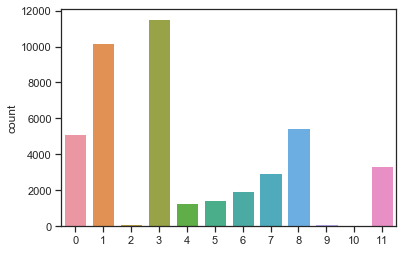

In [309]:
sns.countplot(x=labels);

In [321]:
df_location = df[['Car ID', 'City', 'Latitude_y', 'Longitude_y', 'State', 'cluster_label_y']]

In [324]:
df_location.head(20)

Car ID            City  Latitude_y  Longitude_y State  cluster_label_y
0       92   San Francisco    0.240971    -0.820969    CA                8
1      279    Hillsborough    0.216854    -0.818469    CA                8
2      445        Berkeley    0.251648    -0.815284    CA                8
3      724        San Jose    0.188699    -0.803155    CA                8
4      972       Santa Ana   -0.258606    -0.673040    CA                3
5     1081     San Leandro    0.235544    -0.811849    CA                8
6     1085       Sunnyvale    0.192158    -0.807857    CA                8
7     1461        Berkeley    0.251581    -0.815273    CA                8
8     1745     Los Angeles   -0.206255    -0.695349    CA                3
9     1759      Evansville    0.266085     0.313165    IN                7
10    1869   Laguna Niguel   -0.290516    -0.666406    CA                3
11    1921  Marina del Rey   -0.231929    -0.691059    CA                3
12    2450     Springfield    0.512054     0.710972    PA                1
13    2635     Los Angeles   -0.216662    -0.687127    CA                3
14    3056         Ontario   -0.222611    -0.663496    CA                3
15    3394       Charlotte   -0.076370     0.531650    NC                7
16    4200         Oshkosh    1.024917     0.281778    WI                1
17    4845     West Covina   -0.221915    -0.673850    CA                3
18    5009   Pleasant Hill    0.265646    -0.808728    CA                8
19    5037          Austin   -0.683902    -0.016798    TX               11

In [330]:
#TOP 10 state and cities by quantity of cars listed 
df.groupby(['State', 'City']).size().sort_values(ascending=False).head(10)

State  City         
CA     Los Angeles      3833
FL     Miami            1141
CA     San Diego         849
TX     Houston           759
NV     Las Vegas         747
CA     San Francisco     718
CO     Denver            654
IL     Chicago           650
HI     Honolulu          644
GA     Atlanta           526
dtype: int64

The results looks reliable visually. We can continue to inspect them.

# WORK ON CLASTERISATION AND DIMENSIONALITY REDUCTION

Let's try to solve the problem of car segmentations based on their parameters with unsupervised clustering techniques. 

## Trsnsform non-numerical variables into dummies

In [287]:
df = pd.concat([df,pd.get_dummies(df.Convertible, prefix="Conv", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['Fuel Type'], prefix="fuel", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['Make'], prefix="Make", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['highValueVehicle'], prefix="value", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['Transmission'], prefix="Trans", drop_first=True)], axis=1)

In [288]:
dummy_column_names = list(pd.get_dummies(df.Convertible, prefix="Conv", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Fuel Type'], prefix="fuel", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Make'], prefix="Make", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['highValueVehicle'], prefix="value", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Transmission'], prefix="Trans", drop_first=True).columns)

## Assign incoming and outcoming variables

In [289]:
X =  df[['Price per day', 'Year', 'Number of seats', 'Number of doors']+dummy_column_names]
#Let's keep one more set for the variable without price
X1 =  df[['Year', 'Number of seats', 'Number of doors']+dummy_column_names]
Y = df["Category_code"]

In [313]:
#Let's see how categories looking
Y.value_counts()/len(Y)

5     0.254751
2     0.149228
11    0.125876
8     0.109987
9     0.101355
4     0.087252
1     0.053986
6     0.038486
3     0.034823
12    0.031206
10    0.010005
13    0.002358
0     0.000572
7     0.000114
Name: Category_code, dtype: float64

In [291]:
# Reduce it to two components for visualization and check how long will it take 
X_pca = PCA(2).fit_transform(X_std)

time_start = time.time()
X_pca = PCA(2).fit_transform(X_std)


print('PSA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PSA done! Time elapsed: 0.08752202987670898 seconds


### UMAP

In [273]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 37.60747003555298 seconds


In [274]:
#we see that the UMAP technique is much longer and let's see how it's looking

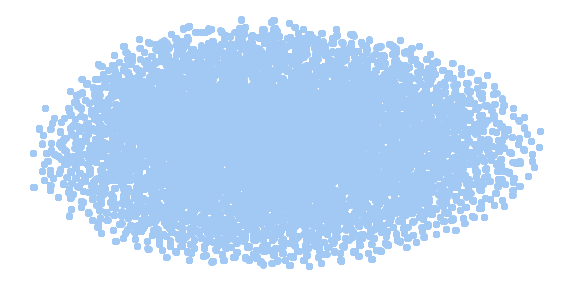

In [275]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

This isn't a good perfomace from a clustering perspective plus the calculation time is too high

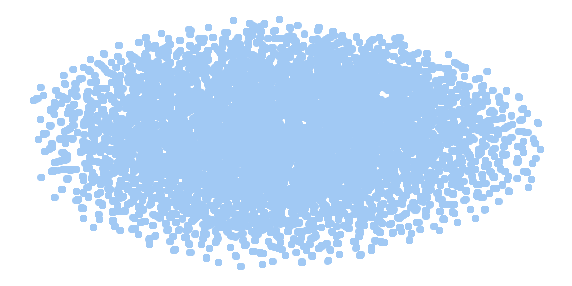

In [276]:
umap_results7 = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(umap_results7[:, 0], umap_results7[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## 6.1. K-Means

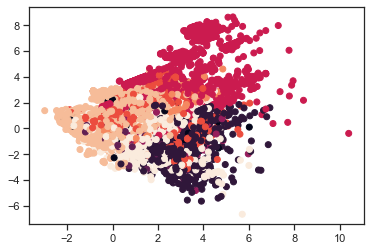

In [277]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=9, random_state=123).fit_predict(X_std)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1],  c=y_pred)
plt.show()

## K-means Evaluation

In [278]:
# Non-labeled verification:

In [279]:
labels = KMeans(n_clusters=7, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_pca, labels, metric='euclidean'))

0.13961588341366074


In [280]:
#the score is very low since our goal is to be closer to 1. Let's try another techniques

## DBSCAN  (psa)

In [281]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [282]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_pca = PCA(2).fit_transform(X_std)
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters_db_pc = dbscan_cluster.fit_predict(X_std)

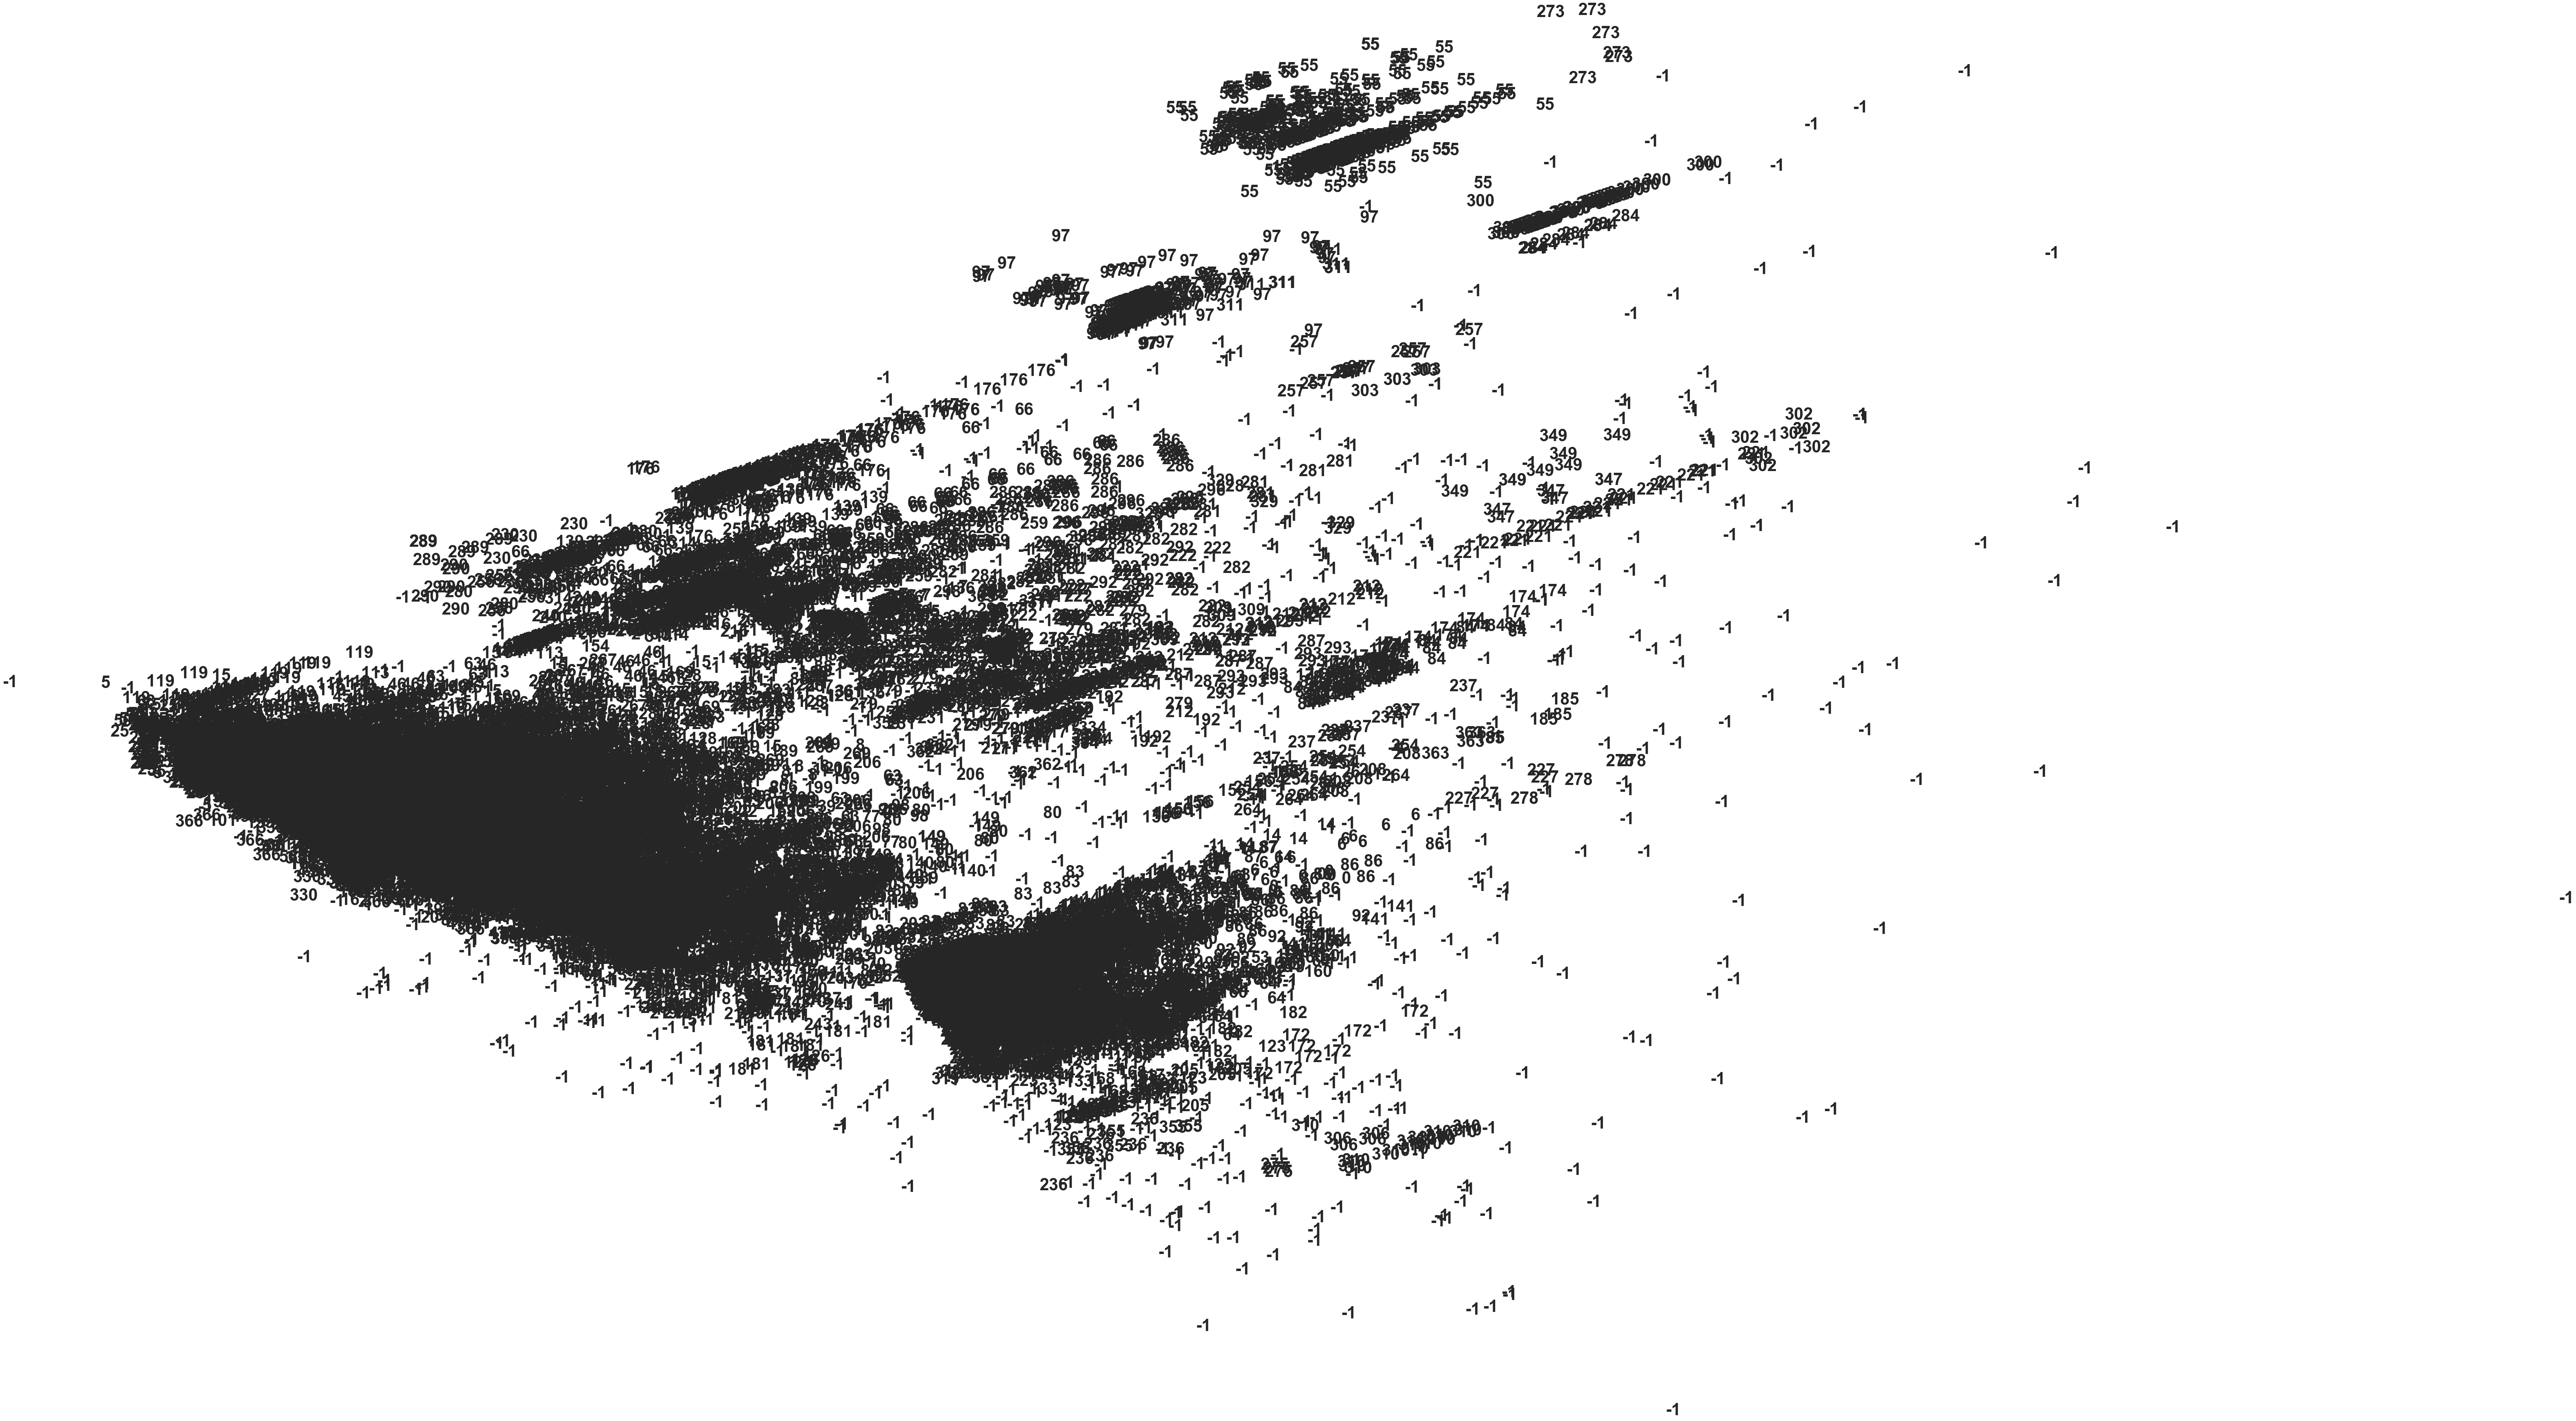

In [283]:
#plot the results
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'

for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters_db_pc[i]),
             fontdict={'weight': 'bold', 'size': 50}
        )
    
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [284]:
print(metrics.silhouette_score(X_std, clusters_db_pc, metric='euclidean'))

0.5179374100527134


### DBSCAN  (umap)

In [285]:
#The score is much better. Let's try with UMAP dimensinality reduction

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters_umap = dbscan_cluster.fit_predict(umap_results7)

In [286]:
print(metrics.silhouette_score(X_std, clusters_umap, metric='euclidean'))

-0.48776061471306803


This isn't a good number so let's try another way

## Hierarchical clastering (psa)

In [58]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
Xpca = PCA(2).fit_transform(X_std)
from sklearn.cluster import AgglomerativeClustering

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

# Fit model
clusters_h = agg_cluster.fit_predict(X_pca)

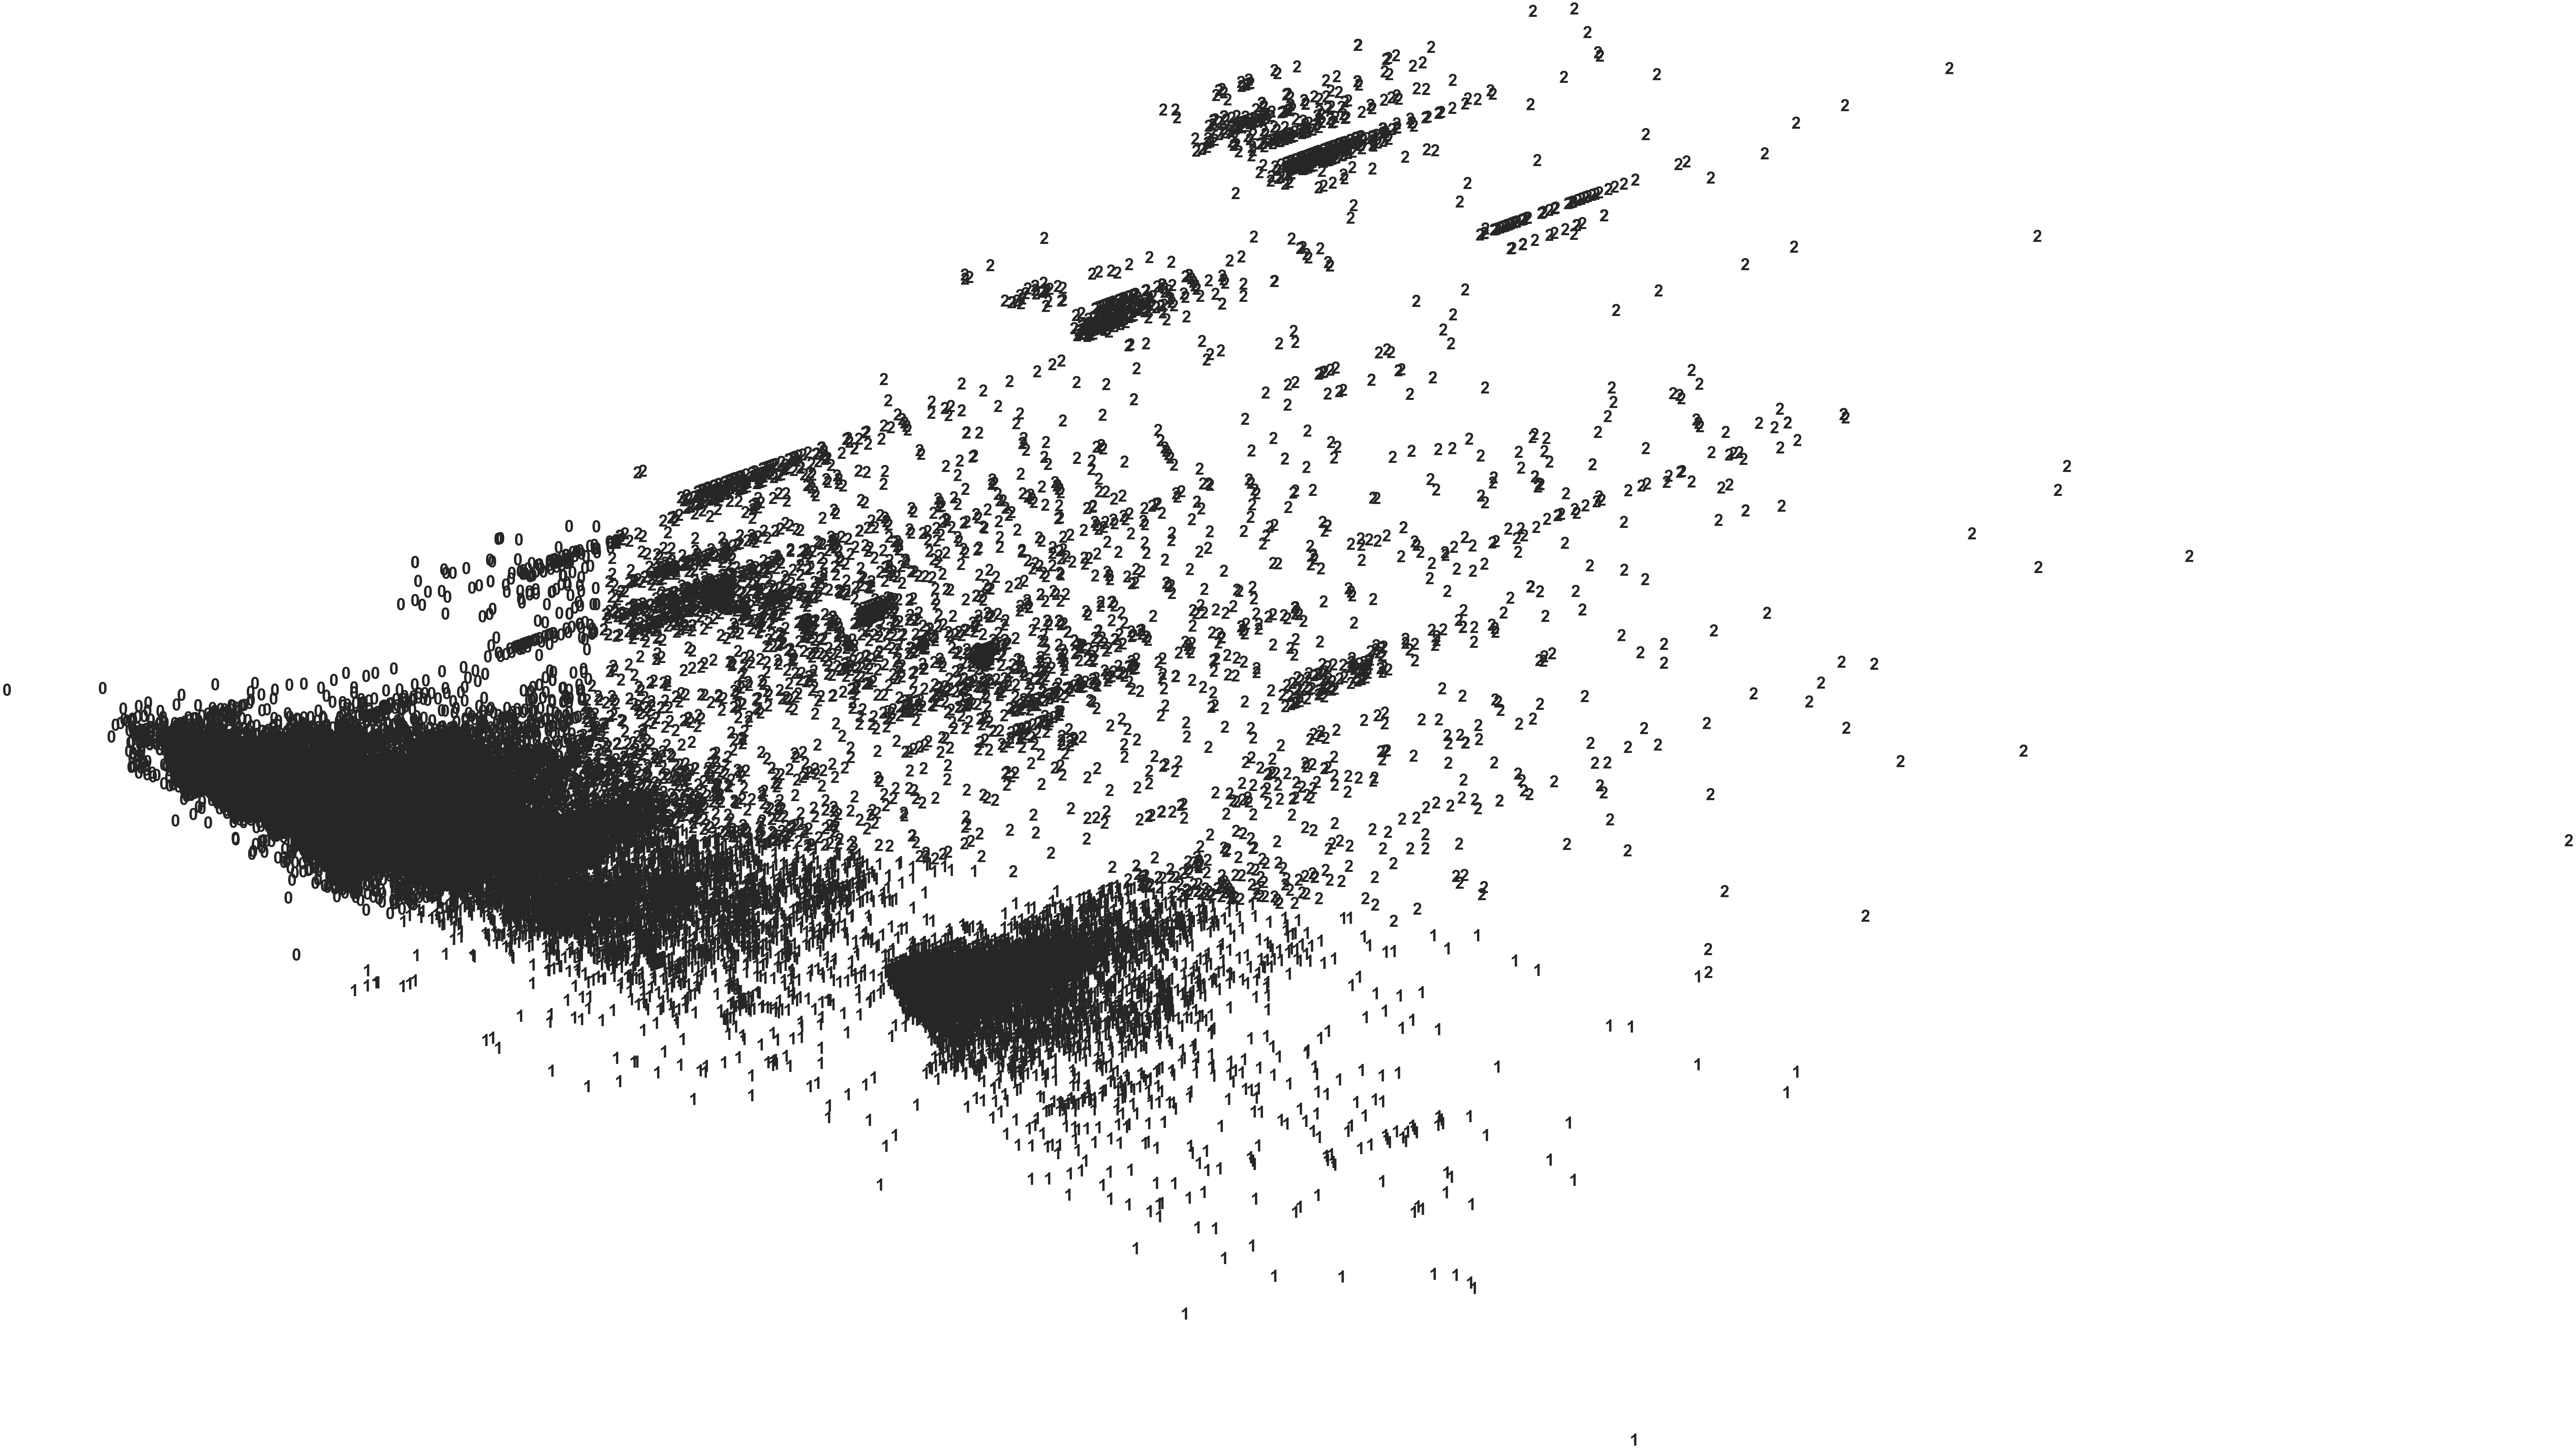

In [59]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters_h[i]),
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [60]:
print(metrics.silhouette_score(X_std, clusters_h, metric='euclidean'))

0.07522371146298965


This one doesn't work this good, let's try with UMAP


## Hierarchical clastering (umap)

In [62]:
print(metrics.silhouette_score(X_std, clusters_h_umap, metric='euclidean'))

-0.0018369254175829987


the rate is very low, we will be skipping it.

### UNSUPERVISED CLUSTERING. CONCLUSION

During unsupervised clustering process we were unable to define clear unsupervised clustering solution for our problem. 
However, based on the silhouette score the best result is coming from DBSCAN clasterisation using pca technique was high we still can't rely on it. We need to go with more sophisticated approach since our variables contain mixed (numeric and non-numeric and categorical) types of data. Also, there are some sort of neural charachteristics for the clusters. 
In this case we need to move forward and try to create a classificator with neural network to be able to assign the category for all new cars that will be added into the system. 

## Multi Layer Perceptron model

The power of neural networks come from their ability to learn the representation in the training data and how to best relate it to the output variable that you want to predict. We will try to use MLP model as well as Random Forest Classifier and compare the performance

In [292]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [293]:
mlp.score(X, Y)

0.6206099180365401

the score is pretty good. Let's try to do a cross validation for this

In [294]:
Y.value_counts()/len(Y)

5     0.254751
2     0.149228
11    0.125876
8     0.109987
9     0.101355
4     0.087252
1     0.053986
6     0.038486
3     0.034823
12    0.031206
10    0.010005
13    0.002358
0     0.000572
7     0.000114
Name: Category_code, dtype: float64

In [295]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X, Y, cv=5)

array([0.55227637, 0.56745623, 0.59512363, 0.50028634, 0.37651775])

The cross validation scores are around 0.54 in average.

Let's try it with the standartized X values - X_std

In [297]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X_std, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [298]:
mlp.score(X_std, Y)

0.7322679609872247

This is definitely much better. We've got our model explained by 10points better when our data is standartized

In [299]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X_std, Y, cv=5)

array([0.60123542, 0.62959149, 0.69013278, 0.72786622, 0.69873998])

#This is a solid result for the data  on average 0.69

Let's try another clasifier to see if our results can go higher

## Random forest classifier

In [300]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, Y, cv=5)

array([0.56074125, 0.59903879, 0.65338828, 0.67678387, 0.65670103])

these numbers are good but the best performance we've got with the 

# CONCLUSIONS
In this capstone we tried to solve the **problem of clustering the data**.
Our original raw data has variables that should be clustered in order to make more precise predictions and to reduce the amount of noise and overfitting. Unsupervised clustering is mainly a process of putting several objects into one bin while models is an ability to predict an outcome. 
Two issues were solved:
- clustering listings by location 
- clustering by car characteristics (price, make, type of fuel, high/not high value of the car

**1. Location clustering:**
The unsupervised learning worked well for clustering numerical information with Lat and Long (we got the silhouette score on the level of 0.65 with k-means
. 

**2. Car category clustering**
    we tried several unsupervised learning techniues but non of them, work good for hybrid variables. We were able to achieve pretty high silghouette score with dbscan (0.84) but it doesn't work good along with the labeled data. We tried another methods as well. K-means and hierarchical clustering are good at finding circular (or convex) clusters, which makes them great tools for identifying well-separated clusters. But, unfortunately, they're not good at identifying clusters that are not well-separated or that have non-convex shapes such as rings inside rings. Anyway, this problem  better should be solved with the supervised model since there are more mixed data involved, it has non-linear connections. For this purpose we used **supervised neural network classifier** that gave us around 0.70 score. We check models with cross validation score to make sure there is no overfitting in the data
These findings are extremelly useful for the development an investment tool in order to predict potential earnings from sharing cars on the platform. We're going to continue our work on this data set in order to increase the relaibality of our calculations.